In [1]:
%reload_ext autoreload
%autoreload
%matplotlib inline

In [2]:
import torch
import torchvision     
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import splitfolders
from PIL import Image
import pathlib 
import pandas as pd 
import torch.nn as nn   
import seaborn as sns   
import torch.utils.data
from datetime import datetime    
from IPython.display import display
import torchvision.transforms as transforms
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix, classification_report
sns.set_style('whitegrid')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#dir of data
DATA_DIR = 'C:/Users/Man/Rice_Image_Dataset'

In [5]:
os.listdir(DATA_DIR)

['Arborio',
 'Basmati',
 'Ipsala',
 'Jasmine',
 'Karacadag',
 'Rice_Citation_Request.txt']

In [6]:
# splitfolders.ratio(input=DATA_DIR, output='Rice', seed=42, ratio=(0.7, 0.15, 0.15))

In [7]:
New_dir = 'C:/Users/Man/Deeplearning razavi/Rice'
#Convert string dir to path object to get better exprience 
New_dir = pathlib.Path(New_dir)
os.listdir(New_dir)

['test', 'train', 'val']

In [8]:
transform = transforms.Compose(
    [
        transforms.Resize((250,250)),
        transforms.ToTensor(),
        transforms.Normalize((0),(1))])


In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    # Add any other transformations here (e.g., normalization)
])
batch_size = 32

In [14]:
transform

Compose(
    ToTensor()
)

In [15]:
train_ds = torchvision.datasets.ImageFolder(
    os.path.join(New_dir, 'train'), transform=transform)

val_ds = torchvision.datasets.ImageFolder(
    os.path.join(New_dir, 'val'), transform=transform)

test_ds = torchvision.datasets.ImageFolder(
    os.path.join(New_dir, 'test'), transform=transform)

print("Train dataset", train_ds,'\n')

print("Validation dataset", val_ds, "\n")

print("Test dataset", test_ds, "\n")

Train dataset Dataset ImageFolder
    Number of datapoints: 52500
    Root location: C:\Users\Man\Deeplearning razavi\Rice\train
    StandardTransform
Transform: Compose(
               ToTensor()
           ) 

Validation dataset Dataset ImageFolder
    Number of datapoints: 11250
    Root location: C:\Users\Man\Deeplearning razavi\Rice\val
    StandardTransform
Transform: Compose(
               ToTensor()
           ) 

Test dataset Dataset ImageFolder
    Number of datapoints: 11250
    Root location: C:\Users\Man\Deeplearning razavi\Rice\test
    StandardTransform
Transform: Compose(
               ToTensor()
           ) 



In [16]:
print(train_ds.class_to_idx,'\n\n', train_ds.classes)

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4} 

 ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [17]:
train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=5
)

val_dl = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, shuffle=True, num_workers=5
)

test_dl = torch.utils.data.DataLoader(
    test_ds, batch_size=batch_size, shuffle=True, num_workers=5
)


In [18]:
for dataset_name, data_loader in {'Train': train_dl, "Validation": val_dl, 'Test': test_dl}.items():
    for images, labels in data_loader:
        # Print the dataset name in bold green
        print(f"Images shape [Batch_size, Channels, Height, Width]: {images.shape}")
        # Output the shape and data type of the labels (y) tensor
        print(f"Labels shape: {labels.shape}, Data type: {labels.dtype}\n")
        # Only show the first batch for brevity
        break

Images shape [Batch_size, Channels, Height, Width]: torch.Size([32, 3, 250, 250])
Labels shape: torch.Size([32]), Data type: torch.int64

Images shape [Batch_size, Channels, Height, Width]: torch.Size([32, 3, 250, 250])
Labels shape: torch.Size([32]), Data type: torch.int64

Images shape [Batch_size, Channels, Height, Width]: torch.Size([32, 3, 250, 250])
Labels shape: torch.Size([32]), Data type: torch.int64



In [19]:
batch_images, labels = next(iter(train_dl))

In [20]:
# Determine and print the number of unique classes in this batch
unique_classes = len(set(labels.numpy()))

In [21]:
labels.shape[0]

32

In [22]:
train_ds.classes

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [23]:
rice_labels = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag"}

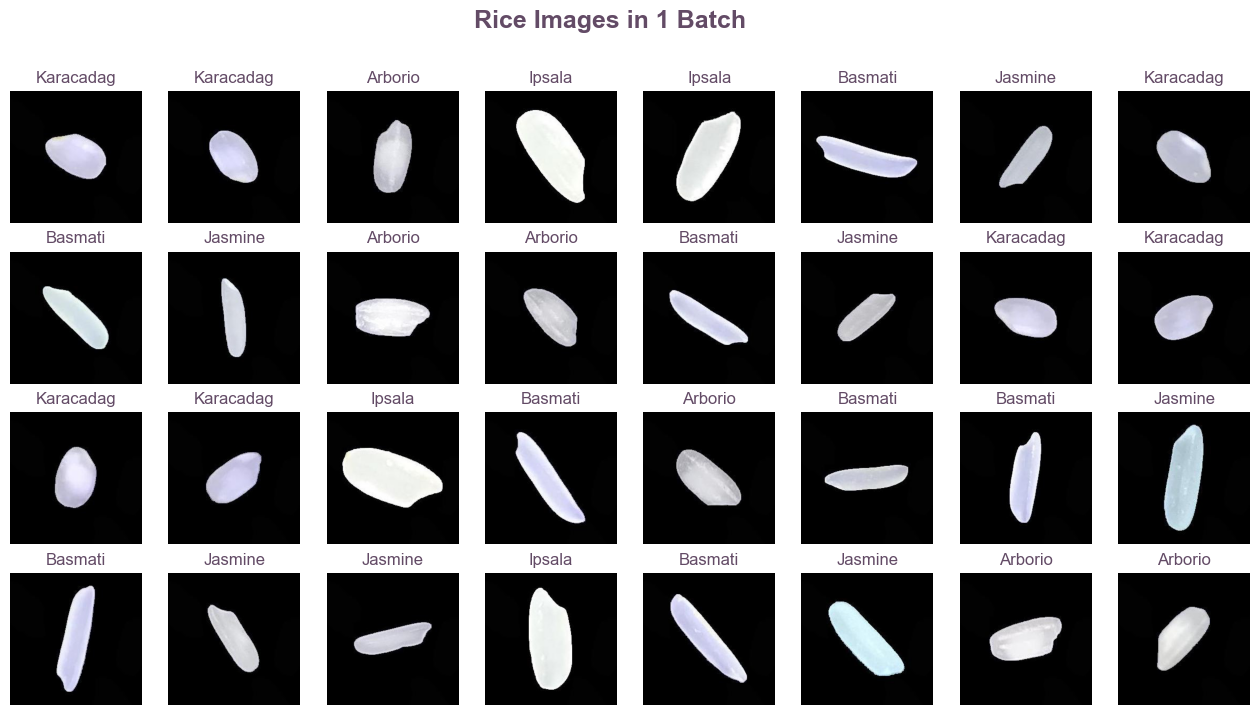

In [24]:
# Visualize 1 batch of images from the training data loader
plt.figure(figsize=(16, 8))
plt.suptitle('Rice Images in 1 Batch', fontsize=18, fontweight='bold', color='#634b66')

# Iterate through the first 32 images in the batch
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    # Permute the image tensor to match the (Height, Width, Channels) format for plotting
    img = torch.permute(batch_images[i], (1, 2, 0))
    plt.imshow(img)
    
    # Get the label corresponding to the current image
    label = rice_labels[int(labels[i])]
    
    # Set the title with the specified color and remove the axis
    plt.title(label, color='#634b66')
    plt.axis('off')
plt.show()


In [25]:
if torch.cuda.is_available():
    print("CUDA is available! PyTorch can use the GPU.")
    device = torch.device("cuda")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}") # Prints name of first GPU
else:
    print("CUDA is NOT available. PyTorch will use the CPU.")
    device = torch.device("cpu")

print(f"Using device: {device}")

CUDA is available! PyTorch can use the GPU.
Number of GPUs available: 1
Current GPU: NVIDIA GeForce GTX 1650
Using device: cuda


In [26]:
# Define a custom Convolutional Neural Network (CNN) class
class CNN(nn.Module):
    def __init__(self, unique_classes):
        super(CNN, self).__init__()
        
        # Convolutional Layers (Feature Extractors)
        self.conv_layers = nn.Sequential(
            # First Convolutional Layer: Input channels = 3 (RGB), Output channels = 32
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),  # Apply ReLU activation function to introduce non-linearity
            nn.MaxPool2d(kernel_size=(2, 2)),  # Reduce spatial dimensions by half
            nn.BatchNorm2d(32),  # Normalize the outputs of the previous layer
            
            # Second Convolutional Layer: Input channels = 32, Output channels = 64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),  # Apply ReLU activation function
            nn.MaxPool2d(kernel_size=(2, 2)),  # Further reduce spatial dimensions
            nn.BatchNorm2d(64),  # Normalize the outputs of the previous layer
            
            # Third Convolutional Layer: Input channels = 64, Output channels = 128
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),  # Apply ReLU activation function
            nn.MaxPool2d(kernel_size=(2, 2)),  # Further reduce spatial dimensions
            nn.BatchNorm2d(128),  # Normalize the outputs of the previous layer
        )
        

        
        # Fully Connected (Dense) Layers (Classifier)
        self.dense_layers = nn.Sequential(
            nn.Linear(107648, 128),  # Fully connected layer: From flattened features to 128 units
            nn.ReLU(),  # Apply ReLU activation function
            nn.Dropout(0.5),
            nn.Linear(128, 64),  # Fully connected layer: From 128 units to 64 units
            nn.ReLU(),  # Apply ReLU activation function
            nn.Linear(64, unique_classes)  # Final layer: From 64 units to the number of classes (e.g., 5 for this model)
        )
    
    # Define the forward pass of the network
    def forward(self, X):
        out = self.conv_layers(X)  # Pass input through the convolutional layers
        out = out.view(out.size(0), -1)  # Flatten the output from the convolutional layers
        out = self.dense_layers(out)  # Pass the flattened output through the dense layers
        return out  # Return the final output (logits or class scores)

# Instantiate the model with the desired number of classes
model = CNN(unique_classes)
dgpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Move the model to the specified device (e.g., GPU if available)
model.to(dgpu)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dense_layers): Sequential(
    (0): Linear(in_features=107648, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, ou

In [27]:
from torchsummary import summary
summary(model, (3, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 29, 29]         --
|    └─Conv2d: 2-1                       [-1, 32, 248, 248]        896
|    └─ReLU: 2-2                         [-1, 32, 248, 248]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 124, 124]        --
|    └─BatchNorm2d: 2-4                  [-1, 32, 124, 124]        64
|    └─Conv2d: 2-5                       [-1, 64, 122, 122]        18,496
|    └─ReLU: 2-6                         [-1, 64, 122, 122]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 61, 61]          --
|    └─BatchNorm2d: 2-8                  [-1, 64, 61, 61]          128
|    └─Conv2d: 2-9                       [-1, 128, 59, 59]         73,856
|    └─ReLU: 2-10                        [-1, 128, 59, 59]         --
|    └─MaxPool2d: 2-11                   [-1, 128, 29, 29]         --
|    └─BatchNorm2d: 2-12                 [-1, 128, 29, 29]         256
├─Se

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 29, 29]         --
|    └─Conv2d: 2-1                       [-1, 32, 248, 248]        896
|    └─ReLU: 2-2                         [-1, 32, 248, 248]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 124, 124]        --
|    └─BatchNorm2d: 2-4                  [-1, 32, 124, 124]        64
|    └─Conv2d: 2-5                       [-1, 64, 122, 122]        18,496
|    └─ReLU: 2-6                         [-1, 64, 122, 122]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 61, 61]          --
|    └─BatchNorm2d: 2-8                  [-1, 64, 61, 61]          128
|    └─Conv2d: 2-9                       [-1, 128, 59, 59]         73,856
|    └─ReLU: 2-10                        [-1, 128, 59, 59]         --
|    └─MaxPool2d: 2-11                   [-1, 128, 29, 29]         --
|    └─BatchNorm2d: 2-12                 [-1, 128, 29, 29]         256
├─Se

In [28]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Number of epochs for training
num_epochs = 5

# Initialize arrays to store loss and accuracy for each epoch
train_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)
train_accs = np.zeros(num_epochs)
val_accs = np.zeros(num_epochs)

# Training loop over the specified number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    t0 = datetime.now()

    
    train_loss = []
    val_loss = []
    n_correct_train = 0
    n_total_train = 0

    # Training phase
    for images, labels in train_dl:
        # Move images and labels to the device (GPU or CPU)
        images = images.to(dgpu)
        labels = labels.to(dgpu)

        # Reset gradients
        optimizer.zero_grad()


        y_pred = model(images)
        loss = criterion(y_pred, labels)  # Compute the loss

        # Backward pass: Compute gradients
        loss.backward()
        optimizer.step()

        # Store the training loss
        train_loss.append(loss.item())

        # Compute training accuracy
        _, predicted_labels = torch.max(y_pred, 1)
        n_correct_train += (predicted_labels == labels).sum().item()
        n_total_train += labels.shape[0]

    train_loss = np.mean(train_loss)
    train_losses[epoch] = train_loss
    train_accs[epoch] = n_correct_train / n_total_train

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    n_correct_val = 0
    n_total_val = 0
    with torch.no_grad():  # No need to track gradients during validation
        for images, labels in val_dl:
            images = images.to(dgpu)
            labels = labels.to(dgpu)

            # Forward pass: Compute predicted labels for validation set
            y_pred = model(images)
            loss = criterion(y_pred, labels)

            # Store the validation loss
            val_loss.append(loss.item())

            # Compute validation accuracy
            _, predicted_labels = torch.max(y_pred, 1)
            n_correct_val += (predicted_labels == labels).sum().item()
            n_total_val += labels.shape[0]

    val_loss = np.mean(val_loss)
    val_losses[epoch] = val_loss
    val_accs[epoch] = n_correct_val / n_total_val
    duration = datetime.now() - t0

    # Print the metrics for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accs[epoch]:.4f} | '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accs[epoch]:.4f} | '
          f'Duration: {duration}')

# Optionally, save the model after training
torch.save(model.state_dict(), "rice_classification_model.pth")

Epoch [1/5] - Train Loss: 0.2581, Train Accuracy: 0.9142 | Val Loss: 0.0688, Val Accuracy: 0.9818 | Duration: 0:03:59.950001
Epoch [2/5] - Train Loss: 0.0941, Train Accuracy: 0.9711 | Val Loss: 0.0521, Val Accuracy: 0.9866 | Duration: 0:03:54.612291
Epoch [3/5] - Train Loss: 0.0573, Train Accuracy: 0.9836 | Val Loss: 0.0592, Val Accuracy: 0.9827 | Duration: 0:03:53.086618
Epoch [4/5] - Train Loss: 0.0535, Train Accuracy: 0.9847 | Val Loss: 0.0371, Val Accuracy: 0.9887 | Duration: 0:03:52.564221
Epoch [5/5] - Train Loss: 0.0375, Train Accuracy: 0.9886 | Val Loss: 0.0193, Val Accuracy: 0.9951 | Duration: 0:03:52.123757
